#Telco Churn

##Librerie

In [406]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sl
import seaborn as sns

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

print(tf.__version__)
print(pd.__version__)
print(np.__version__)
print(sl.__version__)
print(sns.__version__)

2.2.0
1.0.4
1.18.5
0.22.2.post1
0.10.1


## Dataset

In [407]:
# Importazione del dataset in una tabella pandas
url = 'https://raw.githubusercontent.com/rirolli/TelcoChurn/master/Telco-Customer-Churn-train.csv'

telco_data = pd.read_csv(url, na_values=np.nan)

In [408]:
# Stampa delle prime 10 righe del dataset
telco_data.head(10)

,Churn,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,No,4223-BKEOR,Female,0,No,Yes,21,Yes,No,DSL,Yes,No,Yes,No,No,Yes,One year,No,Mailed check,64.85,1336.8
1,No,6035-RIIOM,Female,0,No,No,54,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),97.20,5129.45
2,Yes,3797-VTIDR,Male,0,Yes,No,1,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,23.45,23.45
3,Yes,2568-BRGYX,Male,0,No,No,4,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.20,237.95
4,No,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,
5,No,4291-SHSBH,Male,0,No,No,7,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,69.55,521.35
6,No,4635-EJYPD,Male,0,Yes,Yes,32,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,18.95,613.95
7,No,2607-DHDAK,Male,0,Yes,Yes,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),19.80,1414.65
8,Yes,5204-QZXPU,Male,0,No,No,19,No,No phone service,DSL,No,No,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,39.65,733.35
9,No,0221-NAUXK,Male,0,No,Yes,10,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),19.95,219.5


###Analisi del dataset

La prima cosa da fare è scoprire qual è la forma del dataset:

In [409]:
# Numero di righe e colonne nel dataset
print(f"Shape: {telco_data.shape}")
print(f"Numero di righe (utenti telefonici): {telco_data.shape[0]}")
print(f"Numero di colonne: {telco_data.shape[1]}")

Shape: (5634, 21)
Numero di righe (utenti telefonici): 5634
Numero di colonne: 21


Vediamo di che tipo è ogni colonna del dataset:

In [410]:
telco_data.dtypes

Churn                object
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object

Poi si procede con il vedere se ci sono delle righe con valori non validi (NaN):

In [411]:
# Sostituisco ad ogni stringa vuola il valore 'NaN'
telco_data.replace("", np.nan, inplace=True)
telco_data.replace(" ", np.nan, inplace=True)
telco_data.replace("?", np.nan, inplace=True)

In [412]:
# Controllo dei dati non validi (NaN) nel dataset
telco_data.isna().sum()

Churn                0
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        10
dtype: int64

###Statistiche del dataset

Ora vediamo un po' di statistiche e tabelle del dataset per valutare quali dati sono importanti ai fini dell'addestramento:

In [413]:
# Statistiche del dataset
telco_data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,5634.000000,5634.000000,5634.000000
mean,0.160809,32.373092,64.864253
std,0.367388,24.424539,30.089324
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.750000
50%,0.000000,29.000000,70.525000
75%,0.000000,55.000000,89.937500
max,1.000000,72.000000,118.600000


In [414]:
# Numero dei churn
telco_data['Churn'].value_counts()

No     4138
Yes    1496
Name: Churn, dtype: int64

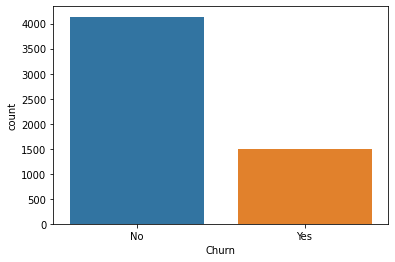

In [415]:
# Diagramma che confronta le persone che hanno lasciato la compagnia telefonica
sns.countplot(telco_data['Churn'])

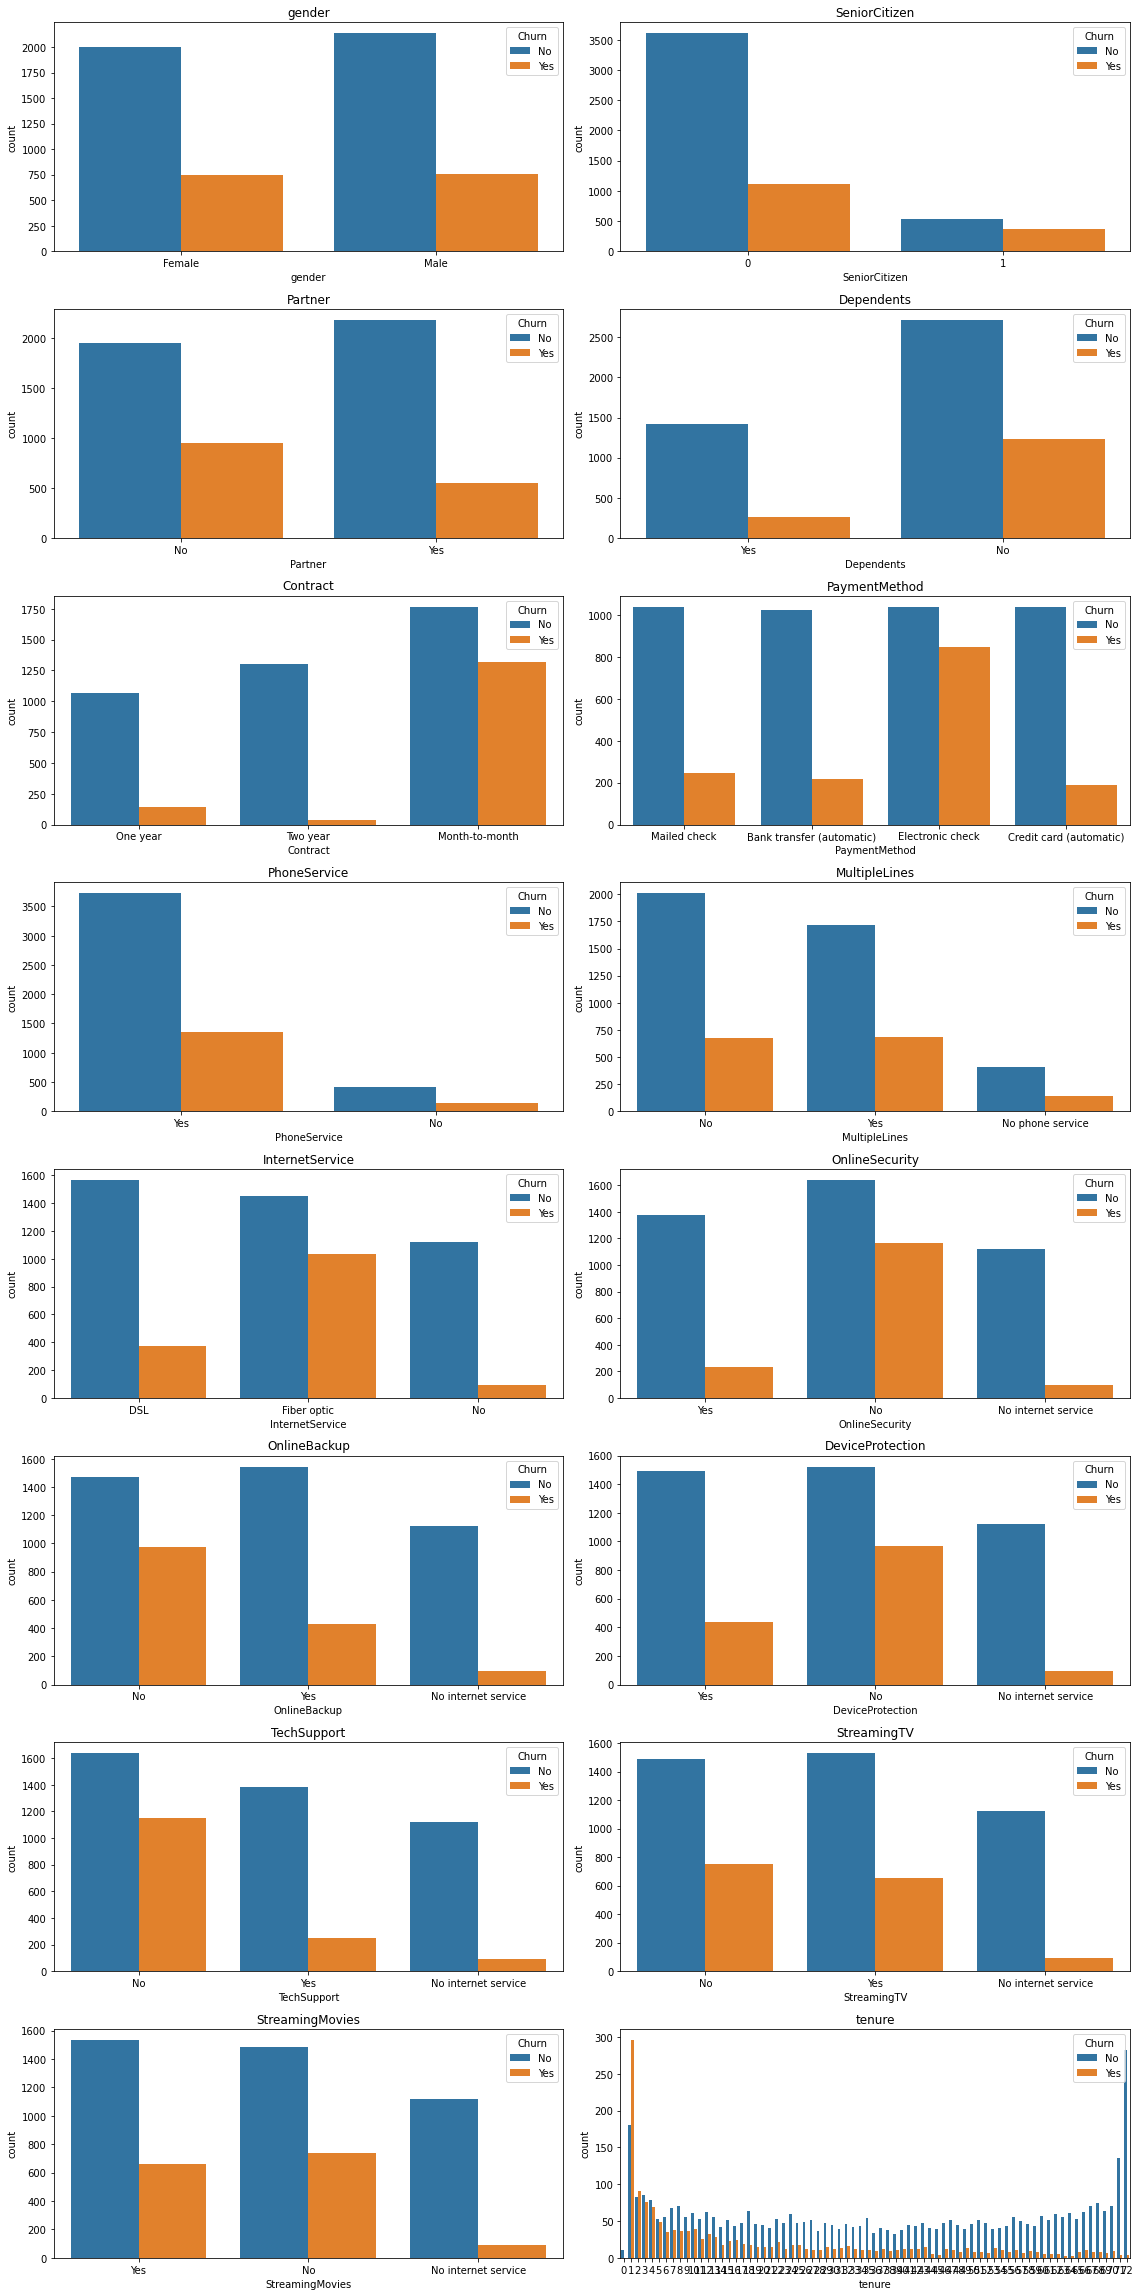

In [416]:
# Alcuni grafici che mettono in relazione le features
# del dataset con le persone che hanno lasciato la compagnia
cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Contract', 'PaymentMethod',
        'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'tenure']

n_rows = 8
n_cols = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*8, n_rows*4))
i=0
for r in range(n_rows):
  for c in range(n_cols):
    ax = axs[r][c]
    sns.countplot(telco_data[cols[i]], hue=telco_data['Churn'], ax=ax)
    ax.set_title(cols[i])
    ax.legend(title='Churn', loc='upper right')
    i+=1

plt.tight_layout()

Dai grafici appena mostrati è evidente come gli attributi ```gender``` e ```partner``` non influenzano la scelta di disdire un contratto con la compagnia telefonica.



In [417]:
# Riepilogo testuale dei valori del dataset
for val in telco_data:
  print(telco_data[val].value_counts())
  print()

No     4138
Yes    1496
Name: Churn, dtype: int64

0480-KYJVA    1
5204-HMGYF    1
0401-WDBXM    1
2619-WFQWU    1
1403-GYAFU    1
             ..
4667-QONEA    1
8745-PVESG    1
2504-DSHIH    1
7317-GGVPB    1
2348-KCJLT    1
Name: customerID, Length: 5634, dtype: int64

Male      2887
Female    2747
Name: gender, dtype: int64

0    4728
1     906
Name: SeniorCitizen, dtype: int64

No     2904
Yes    2730
Name: Partner, dtype: int64

No     3951
Yes    1683
Name: Dependents, dtype: int64

1     476
72    286
2     174
3     161
4     147
     ... 
44     46
39     43
36     43
45     43
0      10
Name: tenure, Length: 73, dtype: int64

Yes    5082
No      552
Name: PhoneService, dtype: int64

No                  2685
Yes                 2397
No phone service     552
Name: MultipleLines, dtype: int64

Fiber optic    2481
DSL            1939
No             1214
Name: InternetService, dtype: int64

No                     2810
Yes                    1610
No internet service    1214
Name: 

###Operazione di preprocessing del dataset

La prima operazione da fare è quella di eliminare tutte le righe che contengono almeno un valore NaN:

In [418]:
# Procediamo con l'eliminazione dei dati non validi (NaN)
telco_data.dropna(inplace=True)

In [419]:
# Controlliamo che non vi siano più nessun valore nullo
telco_data.isna().sum()

Churn               0
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [420]:
# Stampa della nuova shape dopo l'eliminazione delle righe non valide
print(f"Shape: {telco_data.shape}")
print(f"Numero di righe (utenti telefonici): {telco_data.shape[0]}")
print(f"Numero di colonne: {telco_data.shape[1]}")

Shape: (5624, 21)
Numero di righe (utenti telefonici): 5624
Numero di colonne: 21


Successivamente si procede con l'operazione di codifica del dataset. Poiché la rete neurale lavora con i numeri float, per comodità, si è fatta la conversione fin da subito.

In [421]:
# Codifica di tutti i dati del dataset e trasformazione in float64
for elem in telco_data:
  if elem=="MonthlyCharges" or elem=="TotalCharges" or elem=="tenure":
    telco_data[elem] = telco_data[elem].astype('float')
  else:
    telco_data[elem] = (pd.Categorical(telco_data[elem])).codes.astype('float')

In [422]:
telco_data.dtypes

Churn               float64
customerID          float64
gender              float64
SeniorCitizen       float64
Partner             float64
Dependents          float64
tenure              float64
PhoneService        float64
MultipleLines       float64
InternetService     float64
OnlineSecurity      float64
OnlineBackup        float64
DeviceProtection    float64
TechSupport         float64
StreamingTV         float64
StreamingMovies     float64
Contract            float64
PaperlessBilling    float64
PaymentMethod       float64
MonthlyCharges      float64
TotalCharges        float64
dtype: object

In [423]:
# Stampa delle prime 10 righe del dataset codificato
telco_data.head(10)

,Churn,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0.0,2364.0,0.0,0.0,0.0,1.0,21.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,3.0,64.85,1336.80
1,0.0,3448.0,0.0,0.0,0.0,0.0,54.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,1.0,0.0,97.20,5129.45
2,1.0,2143.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,23.45,23.45
3,1.0,1424.0,1.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,70.20,237.95
5,0.0,2394.0,1.0,0.0,0.0,0.0,7.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,69.55,521.35
6,0.0,2593.0,1.0,0.0,1.0,1.0,32.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,3.0,18.95,613.95
7,0.0,1446.0,1.0,0.0,1.0,1.0,72.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,19.80,1414.65
8,1.0,2953.0,1.0,0.0,0.0,0.0,19.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,1.0,2.0,39.65,733.35
9,0.0,103.0,1.0,0.0,0.0,1.0,10.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,19.95,219.50
10,1.0,1911.0,1.0,1.0,1.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,69.10,1474.75


###Ripartizione del dataset

Scegliamo le colonne che **non** vogliamo usare per addestrare la rete neurale.

In [424]:
# Scegliamo la colonna che contiene le soluzioni per l'addestramento
label = 'Churn'

# Di seguito è mostrata la lista contenete le colonne che abbiamo ritenuto
# essere di scarso valore ai fini dell'addestramento
not_features = ['customerID', 'gender', 'Partner']

Eseguiamo lo split del dataset

In [425]:
# Dividiamo il train set in due parti così da poter addestrare la rete:
# y che contiene solo la colonna 'Churn' che consiste nella soluzione al problema
# X che contiene tutte le altre colonne tranne quelle considerate di non interesse.
y = telco_data.pop(label)
X = telco_data.drop(not_features, axis=1)

# Il dataset viene nuovamente diviso in altre parti:
# train_X e train_y che sono le parti usate per l'addestramento;
# val_X e val_y che contengono le parti per la valutazione della rete;
# test_X e test_y per effettuare le predizioni e assicurarsi il corretto
# funzionamento. 
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=.2)
train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=.1)

# I dati vengono poi memorizzati dentro un Dataset di Tensorflow per sfruttarli
# per l'addestramento. Questa stessa operazione viene poi fatta anche per il
# test set e per l'evaluetion set.
train_dataset = (tf.data.Dataset.from_tensor_slices((train_X.values, train_y.values))).shuffle(len(train_X)).batch(1)
val_dataset = (tf.data.Dataset.from_tensor_slices((val_X.values, val_y.values))).shuffle(len(val_X)).batch(1)
test_dataset = (tf.data.Dataset.from_tensor_slices(test_X.values)).batch(1)

In [426]:
print(val_X.shape)

(1125, 17)


In [427]:
telco_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,2364.0,0.0,0.0,0.0,1.0,21.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,3.0,64.85,1336.80
1,3448.0,0.0,0.0,0.0,0.0,54.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,1.0,0.0,97.20,5129.45
2,2143.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,23.45,23.45
3,1424.0,1.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,70.20,237.95
5,2394.0,1.0,0.0,0.0,0.0,7.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,69.55,521.35


##La Neural Network

Per la risoluzione del problema si è scelto di utilizzare una rete neurale stratificata.

###Definizione della rete neurale

Definiamo il modello da utilizzare:

In [428]:
num_inputs = X.shape[1]

In [429]:
model_rn = keras.Sequential([
  tf.keras.layers.Dense(128, input_dim=num_inputs, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1)
])

model_rn.summary()

model_rn.compile(optimizer='adam',
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 128)               2304      
_________________________________________________________________
dense_30 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 129       
Total params: 18,945
Trainable params: 18,945
Non-trainable params: 0
_________________________________________________________________


####Addestramento della rete neurale

Procediamo con l'addestramento della rete neurale.

In [430]:
# Addestramento della rete neurale
history = model_rn.fit(train_dataset, epochs=10)

Epoch 1/10
4049/4049 [==============================] - 5s 1ms/step - loss: 8.7054 - accuracy: 0.7002
Epoch 2/10
4049/4049 [==============================] - 5s 1ms/step - loss: 0.9457 - accuracy: 0.7427
Epoch 3/10
4049/4049 [==============================] - 5s 1ms/step - loss: 0.5156 - accuracy: 0.7661
Epoch 4/10
4049/4049 [==============================] - 5s 1ms/step - loss: 0.5048 - accuracy: 0.7664
Epoch 5/10
4049/4049 [==============================] - 5s 1ms/step - loss: 0.5034 - accuracy: 0.7644
Epoch 6/10
4049/4049 [==============================] - 5s 1ms/step - loss: 0.4939 - accuracy: 0.7698
Epoch 7/10
4049/4049 [==============================] - 5s 1ms/step - loss: 0.4880 - accuracy: 0.7654
Epoch 8/10
4049/4049 [==============================] - 5s 1ms/step - loss: 0.4935 - accuracy: 0.7743
Epoch 9/10
4049/4049 [==============================] - 5s 1ms/step - loss: 0.4778 - accuracy: 0.7659
Epoch 10/10
4049/4049 [==============================] - 5s 1ms/step - loss: 0.474

Nel seguente grafico è possibile visualizzare l'andamento della ```accuracy``` e della ```loss``` all'aumentare delle epoche di addestramento.



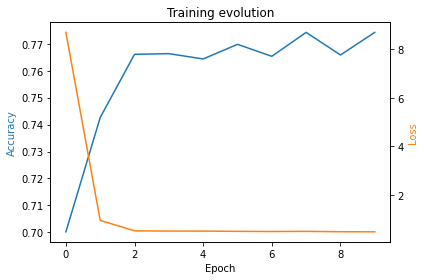

In [431]:
# Grafico che mette in relazione l'andamento dell'accuracy e della loss
# all'aumentare delle epoche di addestramento.
plt.title('Training evolution')
plt.xlabel('Epoch')

color_blue = 'tab:blue'
plt.plot(history.history['accuracy'], color=color_blue)
plt.ylabel('Accuracy', color=color_blue)

plt.twinx()

color_orange = 'tab:orange'
plt.plot(history.history['loss'], color=color_orange)
plt.ylabel('Loss', color=color_orange)

plt.tight_layout()
plt.show()

####Valutazione della rete neurale

Valutiamo l'efficacia del modello tramite un dataset di valutazione.

In [432]:
# Valutazione della rete neurale
val_loss, val_acc = model_rn.evaluate(val_dataset)
print("\nTest accuracy: {:.4f} ({:.2%})\nTest loss: {:.4f}".format(val_acc, val_acc, val_loss))

1125/1125 [==============================] - 1s 989us/step - loss: 0.4378 - accuracy: 0.7911

Test accuracy: 0.7911 (79.11%)
Test loss: 0.4378


####Predizione tramite la rete neurale

Eseguiamo la predizione dei valori presi da un dataset di test e confrontiamoli con le rispettive etichette per valutarne l'efficienza.

In [433]:
# Predizione dei dati tramite la rete neurale
predictions = model_rn.predict(test_dataset)
print("\nAccuracy prediction: {:.4f}".format(accuracy_score(test_y, tf.round(tf.sigmoid(predictions)).numpy())))


Accuracy prediction: 0.7978


Effettuiamo una breve stampa dei valori ottenuti tramite `predict` e degli effettivi valori di `test_y`. Qui vengono mostrato anche il valore di accuratezza della predizione:

In [434]:
# Eseguiamo la stampa dei valori 'predictions' ottenuti tramite
# la predizione con la rete neurale e delle etichette reali 'val_y'.
print("Label\t|  Prediction\t|  Description")
print('-'*45)
for test, pred in zip(test_y, tf.sigmoid(predictions).numpy()):
  message = "{}\t|  {:.2%}\t|  ".format(round(test), pred[0])
  if not test==np.round(pred[0]):
    message += "PREDIZIONE ERRATA"
  print(message)

Label	|  Prediction	|  Description
---------------------------------------------
0	|  20.82%	|  
0	|  13.47%	|  
0	|  23.98%	|  
0	|  12.42%	|  
0	|  16.57%	|  
1	|  25.63%	|  PREDIZIONE ERRATA
1	|  45.26%	|  PREDIZIONE ERRATA
0	|  68.91%	|  PREDIZIONE ERRATA
0	|  12.37%	|  
0	|  5.65%	|  
0	|  27.93%	|  
0	|  25.96%	|  
1	|  51.27%	|  
0	|  4.73%	|  
1	|  29.89%	|  PREDIZIONE ERRATA
0	|  18.69%	|  
0	|  5.74%	|  
1	|  29.49%	|  PREDIZIONE ERRATA
0	|  3.38%	|  
0	|  0.41%	|  
0	|  41.66%	|  
1	|  27.67%	|  PREDIZIONE ERRATA
0	|  24.27%	|  
0	|  5.39%	|  
0	|  83.27%	|  PREDIZIONE ERRATA
0	|  56.73%	|  PREDIZIONE ERRATA
1	|  19.78%	|  PREDIZIONE ERRATA
0	|  15.91%	|  
0	|  5.46%	|  
0	|  14.54%	|  
0	|  4.08%	|  
0	|  26.89%	|  
0	|  16.18%	|  
0	|  13.20%	|  
0	|  1.16%	|  
0	|  40.63%	|  
0	|  12.57%	|  
1	|  14.98%	|  PREDIZIONE ERRATA
0	|  51.97%	|  PREDIZIONE ERRATA
0	|  41.94%	|  
1	|  30.85%	|  PREDIZIONE ERRATA
0	|  4.94%	|  
1	|  44.17%	|  PREDIZIONE ERRATA
0	|  78.12%	|  PREDI

####Confusion Matrix

Tramite i valori ottenuti è possibile generare una `confuion_matrix`:

In [435]:
# Eseguiamo la stampa di una Confusion Matrix dei valori trovati tramite 'predict'
print(confusion_matrix(test_y, tf.round(tf.sigmoid(predictions)).numpy(), normalize=None))

[[309  29]
 [ 62  50]]
